In [0]:
#Installing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#!pip install librosa 
import librosa

Epoch 0 	| Train Loss = 0.081 	| SNR = 1.01
Epoch 10 	| Train Loss = 0.046 	| SNR = 3.91
Epoch 20 	| Train Loss = 0.029 	| SNR = 6.31
Epoch 30 	| Train Loss = 0.021 	| SNR = 7.86
Epoch 40 	| Train Loss = 0.017 	| SNR = 8.89
Epoch 50 	| Train Loss = 0.014 	| SNR = 9.57
Epoch 60 	| Train Loss = 0.012 	| SNR = 10.12
Epoch 70 	| Train Loss = 0.011 	| SNR = 10.56
Epoch 80 	| Train Loss = 0.01 	| SNR = 10.93
Epoch 90 	| Train Loss = 0.009 	| SNR = 11.19
Epoch 100 	| Train Loss = 0.009 	| SNR = 11.49
Epoch 110 	| Train Loss = 0.008 	| SNR = 11.76
Epoch 120 	| Train Loss = 0.008 	| SNR = 11.93
Epoch 130 	| Train Loss = 0.007 	| SNR = 12.14
Epoch 140 	| Train Loss = 0.007 	| SNR = 12.38
Epoch 150 	| Train Loss = 0.007 	| SNR = 12.48
Epoch 160 	| Train Loss = 0.006 	| SNR = 12.62
Epoch 170 	| Train Loss = 0.006 	| SNR = 12.78
Epoch 180 	| Train Loss = 0.006 	| SNR = 12.88
Epoch 190 	| Train Loss = 0.006 	| SNR = 13.11
Epoch 200 	| Train Loss = 0.006 	| SNR = 13.15
Epoch 210 	| Train Loss = 0.005

Text(0.5, 1.0, 'Convergence')

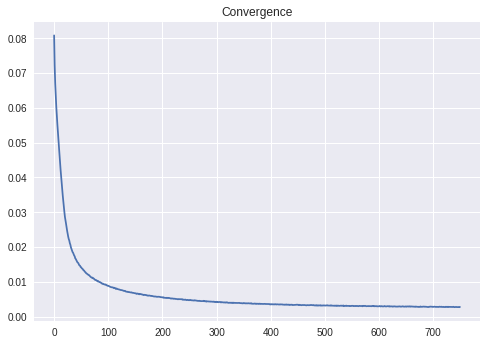

In [58]:
#Speech denoising using 1D CNN
#Importing and converting the audio files
sn, sr=librosa.load('train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)
s, sr=librosa.load('train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)

x_train = np.transpose(np.abs(X))
y_train = np.transpose(np.abs(S))


s1, sr=librosa.load('test_x_01.wav', sr=None)
S1=librosa.stft(s1, n_fft=1024, hop_length=512)
x_test_1 = np.transpose(np.abs(S1))
s2, sr=librosa.load('test_x_02.wav', sr=None)
S2=librosa.stft(s2, n_fft=1024, hop_length=512)
x_test_2 = np.transpose(np.abs(S2))

#Function to calculate SNR
def snr(x,s,p):
  _,phase = librosa.magphase(x)  
  p=librosa.istft(p*phase, hop_length=512,length=len(s))
  a = np.matmul(np.transpose(s),s)
  b = np.matmul(np.transpose(s-p),s-p)
  return 10*np.log10(a/b)

#next_batch function
def next_batch(x,y,start,batch_size):
     return x[start:start + batch_size], y[start:start + batch_size]
                                  
#Network Parameters
n_input = x_train.shape[1]                                  
n_classes = y_train.shape[1] 
n_channels = 1
hidden_units = 256

#Defining hyperparamters
batch_size = 128
n_epoch = 750
display_f = 10
keep_prob = 0.8
learning_rate = 0.0001

#Calc number of iterations in each epoch
n_iter = len(x_train)//batch_size

#FC layer function
def layer(x,hidden_units,name,relu_flag=True):
  input_dim = int(x.get_shape()[1])
  #init = tf.truncated_normal([input_dim,hidden_units],stddev=0.01)  
  w = tf.get_variable('w_' + name,dtype=tf.float32,shape=[x.shape[1], hidden_units],initializer=\
                      tf.contrib.layers.variance_scaling_initializer())
  b = tf.get_variable('b_' + name,dtype=tf.float32,\
                      initializer=tf.constant(0., shape=[hidden_units], dtype=tf.float32))
  if relu_flag ==True:
     return tf.nn.relu(x@w+b)
  else:
     return x@w+b

#Construct the graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32,[None,x_train.shape[1],n_channels])
y = tf.placeholder(tf.float32,[None,y_train.shape[1],n_channels])

#Convolution layer 1
#(513,1) -> (257,30)
conv1 = tf.layers.conv1d(inputs=x, filters=30, kernel_size=3, strides=1,\
                         padding='same', activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

#Convolution layer 2
# (257,30) --> (129,60)
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=60, kernel_size=3, strides=1, 
                             padding='same', activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')

#Flattening the output and using dropout
flat = tf.reshape(max_pool_2, (-1, 129*60))
flat = tf.nn.dropout(flat, keep_prob=keep_prob)

#Fully connected layer for output
#layer_1 = layer(flat,n_classes,'output',True)
layer_out = tf.squeeze(layer(flat,n_classes,'output',False))

#Loss and optimizer
loss = tf.reduce_mean(tf.losses.mean_squared_error(tf.squeeze(y),layer_out))
train_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#Saving the session
saver = tf.train.Saver()

#Running the session
with tf.Session()  as sess:
  err = np.zeros(n_epoch)
  tf.global_variables_initializer().run() 
  tf.local_variables_initializer().run()
  for epoch in range(n_epoch):
   # print('Epoch ', str(epoch))
#     print('_'*30)
    
    for itr in range(n_iter):     
      
      x_batch,y_batch = next_batch(x_train,y_train,itr*batch_size,batch_size)
      x_batch,y_batch = x_batch.reshape([batch_size,y_train.shape[1],n_channels]),y_batch.reshape([batch_size,y_train.shape[1],n_channels])
      
      #Running the session
      sess.run(train_optimizer, feed_dict={x:x_batch,y:y_batch})
    
    #store error and CNN output for SNR calculation
    err[epoch],out = sess.run([loss,layer_out],\
                              feed_dict={x:x_train.reshape([x_train.shape[0],\
                              x_train.shape[1],n_channels]),\
                              y:y_train.reshape([y_train.shape[0],\
                              y_train.shape[1],n_channels])})
    d = np.transpose(out)
    snd = snr(X,s,d)
    
    saver.save(sess, "Model_1")
    if epoch%display_f == 0:
      print("Epoch", str(epoch), "\t| Train Loss =", str(round(err[epoch],3)), "\t| SNR =", str(round(snd,2)))
    
#Plot convergence    
plt.figure()
plt.plot(err)
plt.title('Convergence')    



In [59]:
#First test file
with tf.Session() as sess:
  saver.restore(sess, "Model_1")
  out =sess.run(tf.transpose(layer_out), feed_dict={x:x_test_1.reshape([x_test_1.shape[0],\
                              x_test_1.shape[1],n_channels])})  
_,phase = librosa.magphase(S1)
p=librosa.istft(out*phase, hop_length=512,length=len(s1))   
librosa.output.write_wav('test_s_01_recons.wav', p, sr)
#Code to download the reconstructed noise free file
# from google.colab import files
# files.download('test_s_01_recons.wav')
#Audio display
from IPython.display import *
Audio("test_s_01_recons.wav", autoplay=False)

INFO:tensorflow:Restoring parameters from Model_1


In [60]:
#Second test file
with tf.Session() as sess:
  saver.restore(sess, "Model_1")
  out =sess.run(tf.transpose(layer_out), feed_dict={x:x_test_2.reshape([x_test_2.shape[0],\
                              x_test_2.shape[1],n_channels])})   
_,phase = librosa.magphase(S2)
p=librosa.istft(out*phase, hop_length=512,length=len(s2))   
librosa.output.write_wav('test_s_02_recons.wav', p, sr)
# from google.colab import files
# files.download('test_s_02_recons.wav')
from IPython.display import *
Audio("test_s_02_recons.wav", autoplay=False) 

INFO:tensorflow:Restoring parameters from Model_1


The output of first test file has minute noise at the end and  the second test file the output is a little distorted with small chip noise in the middle. Both of them are better interms of noise compared to the original versions. The performance of 1D CNN output seems to be on lower side compared to fully connected network output.

Epoch 0 	| Train Loss = 0.086 	| SNR = 0.76
Epoch 10 	| Train Loss = 0.054 	| SNR = 3.18
Epoch 20 	| Train Loss = 0.041 	| SNR = 4.64
Epoch 30 	| Train Loss = 0.034 	| SNR = 5.55
Epoch 40 	| Train Loss = 0.023 	| SNR = 7.32
Epoch 50 	| Train Loss = 0.017 	| SNR = 8.65
Epoch 60 	| Train Loss = 0.014 	| SNR = 9.65
Epoch 70 	| Train Loss = 0.012 	| SNR = 10.29
Epoch 80 	| Train Loss = 0.01 	| SNR = 10.89
Epoch 90 	| Train Loss = 0.009 	| SNR = 11.48
Epoch 100 	| Train Loss = 0.008 	| SNR = 11.81
Epoch 110 	| Train Loss = 0.007 	| SNR = 12.16
Epoch 120 	| Train Loss = 0.007 	| SNR = 12.44
Epoch 130 	| Train Loss = 0.006 	| SNR = 12.74
Epoch 140 	| Train Loss = 0.006 	| SNR = 12.96
Epoch 150 	| Train Loss = 0.006 	| SNR = 13.16
Epoch 160 	| Train Loss = 0.005 	| SNR = 13.27
Epoch 170 	| Train Loss = 0.005 	| SNR = 13.48
Epoch 180 	| Train Loss = 0.005 	| SNR = 13.7
Epoch 190 	| Train Loss = 0.005 	| SNR = 13.74
Epoch 200 	| Train Loss = 0.005 	| SNR = 13.96
Epoch 210 	| Train Loss = 0.004 	

Text(0.5, 1.0, 'Convergence')

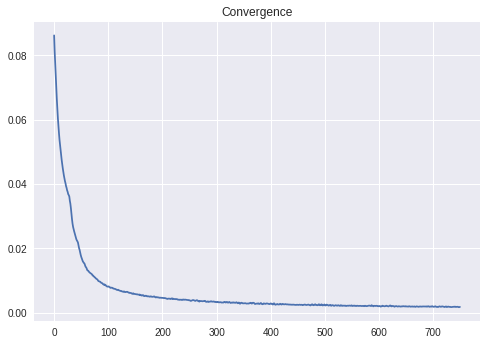

In [52]:
#Speech Denoising using 2D CNN

#function generating images of height 20

def conv_image(x):
  length = x.shape[0]
  width = x.shape[1]
  silent = np.random.rand(19,width)/1000
  x = np.concatenate((silent,x), axis=0)
  X_train_image = np.zeros(shape=(length,20,width))
  for i in range(length):
    X_train_image[i] = x[i:i+20,]
  return X_train_image

#SNR function
def snr(x,s,p):
  _,phase = librosa.magphase(x)  
  p=librosa.istft(p*phase, hop_length=512,length=len(s))
  a = np.matmul(np.transpose(s),s)
  b = np.matmul(np.transpose(s-p),s-p)
  return 10*np.log10(a/b)


#Importing the ausio files, storing and converting to images 
sn, sr=librosa.load('train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)
s, sr=librosa.load('train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)

x_train = np.transpose(np.abs(X))
y_train = np.transpose(np.abs(S))  
x_train_image = conv_image(x_train)

s1, sr=librosa.load('test_x_01.wav', sr=None)
S1=librosa.stft(s1, n_fft=1024, hop_length=512)
x_test_1 = np.transpose(np.abs(S1))
x_test_1_image = conv_image(x_test_1)

s2, sr=librosa.load('test_x_02.wav', sr=None)
S2=librosa.stft(s2, n_fft=1024, hop_length=512)
x_test_2 = np.transpose(np.abs(S2))
x_test_2_image = conv_image(x_test_2)



#next_batch
def next_batch(x,y,start,batch_size):
     return x[start:start + batch_size], y[start:start + batch_size]
                                  
#Network Parameters
n_classes = y_train.shape[1] 
n_channels = 1
hidden_units = 1024

# #Defining hyperparameters
batch_size = 128
n_epoch = 750
display_f = 10
keep_prob = 0.9
learning_rate = 0.0001

#Calc number of iterations in each epoch
n_iter = len(x_train)//batch_size

#FC layer function
def layer(x,hidden_units,name,relu_flag):
  input_dim = int(x.get_shape()[1])
  #init = tf.truncated_normal([input_dim,hidden_units],stddev=0.01)  
  w = tf.get_variable('w_' + name,dtype=tf.float32,shape=[x.shape[1], hidden_units],initializer=\
                      tf.contrib.layers.variance_scaling_initializer())
  b = tf.get_variable('b_' + name,dtype=tf.float32,\
                      initializer=tf.constant(0., shape=[hidden_units], dtype=tf.float32))
  if relu_flag ==True:
     return tf.nn.relu(x@w+b)
  else:
     return x@w+b

#Construct the graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32,[None,20,x_train_image.shape[2],n_channels])
y = tf.placeholder(tf.float32,[None,y_train.shape[1]])


#(513,1) -> (257,30)
conv1 = tf.layers.conv2d(inputs=x, filters=16, kernel_size=[4,4], padding='same', activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],padding='same', strides=[2,2])

# (257,30) --> (129,60)
conv2 = tf.layers.conv2d(inputs=max_pool_1, filters=32, kernel_size=[3,3], 
                             padding='same', activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],padding='same', strides=[2,2])

#Flattening the output and using dropout
flat = tf.reshape(max_pool_2, (-1, 5*129*32))
flat = tf.nn.dropout(flat, keep_prob=keep_prob)

layer_out = tf.squeeze(layer(flat,n_classes,'output',False))


#Loss and optimizer
loss = tf.reduce_mean(tf.losses.mean_squared_error(y,layer_out))
train_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
#Saving the session
saver = tf.train.Saver()

#Running the session
with tf.Session()  as sess:
  err = np.zeros(n_epoch)
  tf.global_variables_initializer().run() 
  tf.local_variables_initializer().run()
  for epoch in range(n_epoch):

    
    for itr in range(n_iter):
      
      
      x_batch,y_batch = next_batch(x_train_image,y_train,itr*batch_size,batch_size)
      x_batch = x_batch.reshape([batch_size,20,y_train.shape[1],n_channels])
      
      sess.run(train_optimizer, feed_dict={x:x_batch,y:y_batch})
    
    #Stroing error and CNN output for SNR calculation
    err[epoch],out = sess.run([loss,layer_out],\
                              feed_dict={x:x_train_image.reshape([x_train_image.shape[0],20,\
                              x_train_image.shape[2],n_channels]),\
                              y:y_train})
    
    d = np.transpose(out)
    snd = snr(X,s,d)    
    #Saving model to a file to be used for scoring
    saver.save(sess, "Model_2")
    
    #Pring the Loss and SNR for each epoch
    if epoch%display_f == 0:      
      print("Epoch", str(epoch), "\t| Train Loss =", str(round(err[epoch],3)), "\t| SNR =", str(round(snd,2)))
    
#plotting convergence    
plt.figure()
plt.plot(err)
plt.title('Convergence')    




In [53]:
#First test file
with tf.Session() as sess:
  saver.restore(sess, "Model_2")
  out =sess.run(tf.transpose(layer_out), feed_dict={x:x_test_1_image.reshape([x_test_1_image.shape[0],20,\
                              x_test_1_image.shape[2],n_channels])})  
_,phase = librosa.magphase(S1)
p=librosa.istft(out*phase, hop_length=512,length=len(s1))   
librosa.output.write_wav('test_s_01_recons_2.wav', p, sr)
#Code to download the reconstructed noise free file
# from google.colab import files
# files.download('test_s_01_recons_2.wav')
#Audio display
from IPython.display import *
Audio("test_s_01_recons_2.wav", autoplay=False)

INFO:tensorflow:Restoring parameters from Model_2


In [54]:
#Second test file
with tf.Session() as sess:
  saver.restore(sess, "Model_2")
  out =sess.run(tf.transpose(layer_out), feed_dict={x:x_test_2_image.reshape([x_test_2_image.shape[0],20,\
                              x_test_2_image.shape[2],n_channels])})   
_,phase = librosa.magphase(S2)
p=librosa.istft(out*phase, hop_length=512,length=len(s2))   
librosa.output.write_wav('test_s_02_recons_2.wav', p, sr)
# from google.colab import files
# files.download('test_s_02_recons.wav')
from IPython.display import *
Audio("test_s_02_recons_2.wav", autoplay=False) 

INFO:tensorflow:Restoring parameters from Model_2


The output of first test file has minute noise at the end and  the second test file the output is a little distorted with small chip noise in the middle. Both of them are better interms of noise compared to the original versions. The performance of 2D CNN is less compared to 1D CNN output.